In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings("ignore")

# Data reading and split

In [2]:
path = 'data_processed/'
gdp = pd.read_csv(path + 'gdp_processed.csv')

data_quart = pd.read_csv(path + 'quart_gt_processed.csv')
data_week = pd.read_csv(path + 'weekly_gt_processed.csv')

Удаляем 2008 год, так как в SVI убираем сезонность с помощью log-diff year2year

In [3]:
gdp['TIME2'] = gdp['TIME'].apply(lambda x: x[:4])
gdp_1 = gdp[gdp['TIME2'] != '2008']

Удаляем 4 квартал 2021 года для РФ, т.к. нет ВВП за этот квартал

In [4]:
data_quart.drop(data_quart.index[2079], inplace=True)

Условие для отеделния 2021 года и последнего квартала 2020 (служит нулевым для построения понедельного ВВП)

In [5]:
cond = np.array(([True] * 47 + [False] * 5) * 45)
cond_rus = np.array([True] * 47 + [False] * 4)

Разделяем на тест и трэйн

In [6]:
gdp_train = pd.concat([gdp_1[gdp_1['LOCATION'] != 'RUS'][cond], gdp_1[gdp_1['LOCATION'] == 'RUS'][cond_rus]])
gdp_test = pd.concat([gdp_1[gdp_1['LOCATION'] != 'RUS'][~cond], gdp_1[gdp_1['LOCATION'] == 'RUS'][~cond_rus]])

In [7]:
data_train = pd.concat([data_quart[data_quart['COUNTRY'] != 'RUS'][cond], 
                        data_quart[data_quart['COUNTRY'] == 'RUS'][cond_rus]])
data_train.reset_index(inplace=True, drop=True)

In [8]:
gdp_train = gdp_train[['LOCATION', 'Value']]

gdp_train.reset_index(inplace=True, drop=True)
gdp_test.reset_index(inplace=True, drop=True)

Считаем разницу между соседними кварталами

In [9]:
arr1 = np.array(gdp_test[gdp_test['LOCATION'] != 'RUS']["Value"])
arr = list(np.array(gdp_test[gdp_test['LOCATION'] != 'RUS']["Value"])[1:])
arr.append(0)

deltas = (np.array(arr) - arr1) / 13

matr = []
for i in range(1, 14):
    matr.append(list(arr1 + i * deltas))

Непосредственно строим понедельный прирост ВВП

In [10]:
arr1 = np.array(gdp_test[gdp_test['LOCATION'] == 'RUS']["Value"])

arr = list(np.array(gdp_test[gdp_test['LOCATION'] == 'RUS']["Value"])[1:])
arr.append(0)

deltas = (np.array(arr) - arr1) / 13

matr2 = []
for i in range(1, 14):
    matr2.append(list(arr1 + i * deltas))

In [11]:
cond2 = ([True] * 4 + [False]) * 45

Получаем понедельный прирост для РФ и др стран

In [12]:
gdp_test2 = np.array(matr).T[cond2]
gdp_test2_rus = np.array(matr2).T[:3]

Объединяем результаты

In [13]:
gdp_test_final = np.array([])

for i in list(gdp_test2):
    gdp_test_final = np.hstack([gdp_test_final, i])
    
for i in list(gdp_test2_rus):
    gdp_test_final = np.hstack([gdp_test_final, i])

In [14]:
locs = []
for tick in gdp_test['LOCATION'].unique():
    const = 52
    if tick =='RUS':
        const = 39
    locs += [tick] * const

In [15]:
gdp_test_final = pd.DataFrame(gdp_test_final, columns=['value'])

gdp_test_final['location'] = locs
gdp_test_final = gdp_test_final.sort_values(by=['location'], kind='stable')

gdp_test_final = pd.get_dummies(gdp_test_final)

In [16]:
data_week_final = pd.concat([data_week[data_week['COUNTRY'] != 'RUS'], 
                        data_week[data_week['COUNTRY'] == 'RUS'].loc[2028:2066]])
data_week_final = data_week_final.sort_values(by=['COUNTRY'], kind='stable')

data_week_final = pd.get_dummies(data_week_final)

Разделение получившихся данных на валидацию и тест (делим пополам, так как в целом нам хватает данных для достаточно репрезентативных валидации и теста)

In [17]:
val_cond = np.array(([True] * 26 + [False] * 26) * 39 + 
                     [True] * 20 + [False] * 19 + 
                    ([True] * 26 + [False] * 26) * 6)

In [18]:
X_val, X_test = data_week_final[val_cond], data_week_final[~val_cond]
y_val, y_test = gdp_test_final[val_cond]['value'], gdp_test_final[~val_cond]['value']

X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

Тренировочная выборка

In [19]:
data_train = data_train.sort_values(by=['COUNTRY', 'date'], kind='stable')
gdp_train = gdp_train.sort_values(by=['LOCATION'], kind='stable')
data_train.drop(columns=['date'], inplace=True)

X_train = pd.get_dummies(data_train)
y_train = pd.get_dummies(gdp_train)["Value"]

In [20]:
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Models training

### Статистические модели

Из-за того, что часть библиотек для статистических моделей не работала корректно в JupyterNotebook, кроме того, для них нужен несколько другая предобработка, поэтому тут будет небольшой вступительный код по предобработке данных (он основывается на том, что было выше). Кроме того, тут не будет использоваться валидационная выборка, поскольку не так много гиперпараметров, которые надо оптимизировать.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/quart_gt_processed.csv').drop(columns=['date'])


# создадим колонку с датами
date = pd.read_csv('/content/drive/MyDrive/GoogleTrends_BG.csv')['date'][15::3]
date = date.reset_index(drop=True)
x = date.copy()
for i in range(45):
    x = pd.concat((x, date), axis=0)
x = x.reset_index(drop=True)
data_touse = pd.concat([data, x], axis=1)

gdp = pd.read_csv('/content/drive/MyDrive/gdp_processed.csv')
gdp_1 = gdp[(gdp['TIME'] != '2008-Q1') &  (gdp['TIME'] != '2008-Q2') & (gdp['TIME'] != '2008-Q3') & (gdp['TIME'] != '2008-Q4')]
# уберем индекс по России (нет ВВП за этот период)
data_touse.drop(data_touse.index[2079], inplace=True)

In [4]:
gdp_1 = gdp_1.rename(columns={'LOCATION': 'COUNTRY'})
gdp_1 = gdp_1.sort_values(['COUNTRY', 'TIME']).reset_index()

In [5]:
data_full = pd.concat([data_touse.sort_values(['COUNTRY', 'date']).reset_index(), gdp_1['Value']], axis=1)

In [ ]:
# !pip install orbit-ml
# !pip install sktime[all_extras]

In [6]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from orbit.models.lgt import LGT
from orbit.models.dlt import DLT

In [7]:
# прочитаем недельные данные
data_week = pd.read_csv('/content/drive/MyDrive/weekly_gt_processed.csv')

# для того, что модели выдавали корректное предсказание, надо сделать даты
date = []
for i in range(52):
    month = (1 + i * 3) % 12
    mask = (month < 10) * '0'
    year = 2021 + (1 + i * 3) // 12
    k = str(year) + '-' + mask + str(month) + '-01'
    date.append(k)
date = pd.Series(date, name='date')

In [24]:
def preprocessing(country, orbit=True):
    X_train = data_full[data_full['COUNTRY'] == country].iloc[:47]
    # тут мы получаем ВВП по кварталам за тестовый период
    y_test = data_full[data_full['COUNTRY'] == country]['Value'].iloc[47:]
    # линейная аппроксимация ВВП по неделям
    arr = list(y_test[1:])
    deltas = (np.array(arr) - y_test[:-1].values) / 13

    y_week = []
    for j in range(len(deltas)):
        for k in range(1, 14):
            y_week.append(y_test.iloc[j] +  k * deltas[j])
    y_week = pd.Series(y_week, name='Value')

    dt = pd.Series(date[:len(y_week)], name='date')
    
    # тест представляет собой недельные данные 
    X_test = pd.concat([data_week[data_week['COUNTRY'] == country].iloc[:len(y_week)].reset_index(), dt], axis=1)
    X_test = pd.concat([X_test, y_week], axis=1)
    # если имеем дело не с библиотекой орбит, то надо сделать ряд, с которым будет удобно работать
    if not orbit:
        trains_ts = pd.Series(data=X_train['Value'].values, index=X_train['date'].values)
        trains_ts.index.freq="Q"
        trains_ts.index = pd.PeriodIndex(trains_ts.index, freq="Q")

        test_ts = pd.Series(data=X_test['Value'].values, index=X_test['date'].values)
        test_ts.index.freq= "Q"
        test_ts.index = pd.PeriodIndex(test_ts.index, freq="Q")

        fh = ForecastingHorizon(test_ts.index, is_relative=False)

        return trains_ts, test_ts, fh
    return X_train, X_test

#### DLT

In [25]:
# обучим на всех колонках (то есть вс)
dlt_full = []
for i in data_full['COUNTRY'].unique():
    X_train, X_test = preprocessing(i)
    
    dlt = DLT(
    response_col='Value', 
    date_col='date',
    regressor_col=X_test.drop(columns=['Value', 'date', 'COUNTRY']).columns,
    seasonality=4)
    
    
    dlt.fit(X_train)
    predicted_df = dlt.predict(df=X_test)
    
    dlt_full.append(mean_squared_error(predicted_df['prediction'], X_test['Value'].values))
    print(i ,':', mean_squared_error(predicted_df['prediction'], X_test['Value'].values))

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ARG : 109.01327366341094


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


AUS : 166.92494108919283


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


AUT : 57.534313175416735


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


BEL : 556.266795210954


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


BGR : 2.2942851291238835


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


BRA : 254.81833261011934


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CAN : 401.4738038416233


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CHE : 97.30752332862133


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CHL : 521.6656492222193


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


COL : 463.1498492681918


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CRI : 204.832267457229


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CZE : 51.24212676124019


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


DEU : 221.30878725181265


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


DNK : 74.23193349217685


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ESP : 636.4605844874516


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


EST : 61.88396601145398


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


FIN : 7.822853715432239


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


FRA : 141.36195149406169


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


GBR : 181.21018778033633


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


GRC : 507.88321115662745


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


HUN : 119.4936002830929


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


IDN : 16.837279232980187


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


IND : 351.964432170228


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


IRL : 209.22112879970277


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ISL : 40.132188518064694


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ISR : 40.27059479208815


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ITA : 83.2201834753984


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


JPN : 141.18337512029728


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


KOR : 43.73624717368245


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


LTU : 21.992047255996873


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


LUX : 126.7057424034127


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


LVA : 22.256090499042788


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


MEX : 512.6267751854996


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


NLD : 17.914466699352168


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


NOR : 43.4114461646038


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


NZL : 214.10886892558955


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


POL : 47.20008891747546


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


PRT : 117.13013748845097


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ROU : 66.41931130873495


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


RUS : 89.13811855057462


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


SVK : 20.916951471605817


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


SVN : 45.299031578422436


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


SWE : 34.797068245696515


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


TUR : 92.25721108942777


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


USA : 10.932331307940663


ZAF : 97.91538853685383


In [26]:
# возьмем 10 наиболее коррелированных колонок
corrs = np.abs(X_train.corr()['Value']).sort_values()[-11:-1].index

# обучим DLT на них
dlt_corr = []
for i in data_full['COUNTRY'].unique():
    X_train, X_test = preprocessing(i)
    
    dlt = DLT(
    response_col='Value', 
    date_col='date',
    regressor_col=corrs,
    seasonality=4)
    
    
    dlt.fit(X_train)
    predicted_df = dlt.predict(df=X_test)
    
    dlt_corr.append(mean_squared_error(predicted_df['prediction'], X_test['Value'].values))
    print(i ,':', mean_squared_error(predicted_df['prediction'], X_test['Value'].values))

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ARG : 401.40415151538014


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


AUS : 79.23600368281245


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


AUT : 98.28558215139712


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


BEL : 82.54968882670389


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


BGR : 60.08505779693515


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


BRA : 206.1922756776997


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CAN : 66.45627811694885


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CHE : 9.517486859880218


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CHL : 386.4586200217545


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


COL : 392.88877340023157


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CRI : 127.42558011722566


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CZE : 27.705042804847764


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


DEU : 13.324320320610655


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


DNK : 6.580093575816329


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ESP : 80.59281725101762


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


EST : 366.1711543292461


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


FIN : 5.148641537592763


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


FRA : 44.17674116890425


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


GBR : 172.61186353843553


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


GRC : 459.18005765279327


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


HUN : 107.60522606898338


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


IDN : 128.1866466123649


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


IND : 292.2741172670081


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


IRL : 97.51383029737391


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ISL : 37.799697192790546


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ISR : 44.94635839067601


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ITA : 387.76063317503736


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


JPN : 61.19667975182535


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


KOR : 4.238172364919929


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


LTU : 25.29263401344551


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


LUX : 17.373488914247478


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


LVA : 11.434815110457645


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


MEX : 388.92933040045216


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


NLD : 26.909929400916116


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


NOR : 61.371388902557975


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


NZL : 34.13359025688378


POL : 27.632565726497432


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


PRT : 45.03091021813071


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ROU : 79.51705148943263


RUS : 87.48468032839413


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


SVK : 21.03217518310238


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


SVN : 38.28639680446845


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


SWE : 9.679910372842361


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


TUR : 145.90256553105766


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


USA : 15.499070840838032


ZAF : 154.3645184514448


In [27]:
# попробуем убрать сезонность
dlt_corr_seas = []
for i in data_full['COUNTRY'].unique():
    X_train, X_test = preprocessing(i)
    
    dlt = DLT(
    response_col='Value', 
    date_col='date',
    regressor_col=corrs)
    
    
    dlt.fit(X_train)
    predicted_df = dlt.predict(df=X_test)
    
    dlt_corr_seas.append(mean_squared_error(predicted_df['prediction'], X_test['Value'].values))
    print(i ,':', mean_squared_error(predicted_df['prediction'], X_test['Value'].values))

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ARG : 512.6624680597549


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


AUS : 61.17522759717905


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


AUT : 54.609266411686185


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


BEL : 22.9350615753055


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


BGR : 37.37050008072215


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


BRA : 205.33260712634467


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CAN : 102.26361185327129


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CHE : 11.64314808036326


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CHL : 433.567516638513


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


COL : 455.8323538605941


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CRI : 120.3007135391643


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


CZE : 39.74270736423633


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


DEU : 15.056105056893834


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


DNK : 9.087029706964234


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ESP : 36.14507965352542


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


EST : 955.9858935487342


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


FIN : 7.035804628782669


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


FRA : 35.781986801790886


GBR : 64.62817640661882


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


GRC : 461.9531601350933


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


HUN : 232.6773725558678


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


IDN : 82.51250589095208


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


IND : 101.24454228226881


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


IRL : 206.58911396128212


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ISL : 63.00466470709367


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ISR : 16.529002166899772


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ITA : 648.1196167457549


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


JPN : 17.981612334261946


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


KOR : 5.27779292437134


LTU : 61.05241543207747


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


LUX : 25.037830824413472


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


LVA : 7.961259723794952


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


MEX : 338.3350823399674


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


NLD : 14.620681052739426


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


NOR : 56.95048090103573


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


NZL : 52.558945363103845


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


POL : 31.352622812005304


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


PRT : 32.81980005648415


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


ROU : 81.23653105199736


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


RUS : 47.437789262338555


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


SVK : 41.25619837036296


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


SVN : 43.85822897475911


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


SWE : 10.652818324604956


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


TUR : 252.91507393078257


INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


USA : 14.478531862395045


ZAF : 196.63053457074653


Также была рассмотрена модель LGT, но оказалась нерабочей по причине того, что она не может работать с отрицательными значениями в столбцах регрессеров, а у нас такие есть.

#### Exponential Smoothing

In [28]:
es_list = []
for i in data_full['COUNTRY'].unique():
    trains_ts, test_ts, fh = preprocessing(i, orbit=False)
    
    es = ExponentialSmoothing().fit(trains_ts)
    y_pred = es.predict(fh)

    es_list.append(mean_squared_error(y_pred, test_ts.values))
    print(i, ':', mean_squared_error(y_pred, test_ts.values))

ARG : 421.55063650558384
AUS : 70.4097934851262
AUT : 131.71464954443655
BEL : 143.17117780360243
BGR : 75.92041440682809
BRA : 87.75413824522903
CAN : 115.25956636778704
CHE : 35.44734560702676
CHL : 489.0007817287333
COL : 404.24444837792765
CRI : 207.7704503378471
CZE : 77.99206849022093
DEU : 64.56988895790899
DNK : 41.834940283557096
ESP : 273.47210412195693
EST : 123.6605501472367
FIN : 32.896363346662085
FRA : 206.93250822007926
GBR : 358.3407387735952
GRC : 362.4960009667624
HUN : 173.93477605722967
IDN : 49.076113270306614
IND : 300.50875682580386
IRL : 34.372288782908456
ISL : 145.15949511788597
ISR : 108.77489325925566
ITA : 216.58064287279538
JPN : 56.486882544586855
KOR : 22.228502813575126
LTU : 28.14522419241613
LUX : 71.18578642046023
LVA : 61.48180210234562
MEX : 271.36159829711386
NLD : 79.63698996946958
NOR : 24.08517184224657
NZL : 78.01515313573414
POL : 69.9871103082411
PRT : 196.00418008515805
ROU : 157.71561184611755
RUS : 37.94226441577935
SVK : 38.951924681715

#### ARIMA, AutoARIMA

In [29]:
from sktime.forecasting.arima import ARIMA


arima_list = []
for i in data_full['COUNTRY'].unique():
    trains_ts, test_ts, fh = preprocessing(i, orbit=False)

    ar = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 4), scoring='mse')
    ar.fit(trains_ts)
    y_pred = ar.predict(fh)

    arima_list.append(mean_squared_error(y_pred, test_ts.values))
    print(i, ':', mean_squared_error(y_pred, test_ts.values))

ARG : 377.8225534049711
AUS : 39.25930373798547
AUT : 258.89146191984923
BEL : 58.61047009236207
BGR : 39.34767180043071
BRA : 79.95554175916305
CAN : 121.71570207609156


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


CHE : 9.996684285582658
CHL : 712.9078019815909
COL : 579.5108305230013
CRI : 199.05576588356112
CZE : 34.254161556605595
DEU : 45.616581044402466
DNK : 14.791793088380045
ESP : 280.78831327822667
EST : 12.907113430447488
FIN : 4.911946418530506
FRA : 82.76633948348714
GBR : 576.9715076639327
GRC : 286.5436909767657
HUN : 159.21523407299745
IDN : 116.48921958867066
IND : 797.7294904377311
IRL : 37.0233539457459
ISL : 85.81872660045484
ISR : 56.60109761995474
ITA : 75.59395148364443
JPN : 39.76784531057661
KOR : 15.2521015171662
LTU : 20.29349889044611
LUX : 21.077745947243343
LVA : 12.873830528735077
MEX : 359.8124200564394
NLD : 79.29023166254085
NOR : 19.78760826902645
NZL : 103.1145446738776
POL : 112.82820413063092
PRT : 53.36295786546514
ROU : 131.35094343799244
RUS : 9.600176223364537
SVK : 12.055859900620657
SVN : 31.2622243615722
SWE : 26.16749503279066
TUR : 52.12235880376141
USA : 26.13335996083077
ZAF : 392.05890279117017


In [35]:
from sktime.forecasting.arima import AutoARIMA

autoarima_list = []
for i in data_full['COUNTRY'].unique():
    trains_ts, test_ts, fh = preprocessing(i, orbit=False)

    sar = AutoARIMA(start_p=1, d=0, start_q=0, 
                       max_p=2, max_d=1, max_q=0, 
                       start_P=1, D=1, start_Q=0, 
                       max_P=2, max_D=2, max_Q=2, 
                       sp=4, suppress_warnings=True, stepwise=False, n_jobs=-1)

    sar.fit(trains_ts)
    y_pred = sar.predict(fh)

    autoarima_list.append(mean_squared_error(y_pred, test_ts.values))
    print(i, ':', mean_squared_error(y_pred, test_ts.values))

ARG : 374.42742969513074
AUS : 77.57399760633463
AUT : 308.87671677739644
BEL : 247.45814331072341
BGR : 13.262487144423819
BRA : 112.1731306335141
CAN : 78.52419146576392
CHE : 44.69571333856736
CHL : 457.924752419155
COL : 371.8551496817411
CRI : 351.40307490893196
CZE : 31.42990528384593
DEU : 43.37137746736141
DNK : 26.785981036590172
ESP : 682.2109370917401
EST : 7.911536094564752
FIN : 6.929203163154607
FRA : 374.980467389205
GBR : 594.1615107400929
GRC : 472.7315808174665
HUN : 81.48271090940838
IDN : 918.4199958604781
IND : 2537.3418220709955
IRL : 27.85144762325871
ISL : 94.17264031745968
ISR : 98.2502058907672
ITA : 406.2663299109559
JPN : 52.34239074990773
KOR : 13.822261410920769
LTU : 33.618547854698214
LUX : 25.77941052668967
LVA : 64.6699623727275
MEX : 354.2296147587883
NLD : 120.27465400574077
NOR : 12.533997508597762
NZL : 112.21508698650918
POL : 36.57683274316708
PRT : 428.0682018000155
ROU : 184.0759214489471
RUS : 18.964628163847696
SVK : 21.345497300416756
SVN : 

In [36]:
res = pd.DataFrame({'country': data_full['COUNTRY'].unique(), 'DLT_full_sp':dlt_full, 'DLT_corr_sp':dlt_corr, 'DLT_corr':dlt_corr_seas, 'ExpSmooth': es_list, 'ARIMA': arima_list, 'AutoARIMA':autoarima_list})
res.to_csv('res.csv')

In [37]:
res

,country,DLT_full_sp,DLT_corr_sp,DLT_corr,ExpSmooth,ARIMA,AutoARIMA
0,ARG,109.013274,401.404152,512.662468,421.550637,377.822553,374.427430
1,AUS,166.924941,79.236004,61.175228,70.409793,39.259304,77.573998
2,AUT,57.534313,98.285582,54.609266,131.714650,258.891462,308.876717
3,BEL,556.266795,82.549689,22.935062,143.171178,58.610470,247.458143
4,BGR,2.294285,60.085058,37.370500,75.920414,39.347672,13.262487
5,BRA,254.818333,206.192276,205.332607,87.754138,79.955542,112.173131
6,CAN,401.473804,66.456278,102.263612,115.259566,121.715702,78.524191
7,CHE,97.307523,9.517487,11.643148,35.447346,9.996684,44.695713
8,CHL,521.665649,386.458620,433.567517,489.000782,712.907802,457.924752
9,COL,463.149849,392.888773,455.832354,404.244448,579.510831,371.855150


In [38]:
res.describe()

,DLT_full_sp,DLT_corr_sp,DLT_corr,ExpSmooth,ARIMA,AutoARIMA
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,159.690581,118.204057,137.526075,140.520241,144.854535,250.729668
std,170.801311,133.213020,198.974087,118.391871,194.070268,424.911893
min,2.294285,4.238172,5.277793,22.228503,4.911946,6.929203
25%,43.492646,27.090588,23.460754,57.735612,26.141894,29.781233
50%,94.782367,63.913834,53.584106,89.911734,57.605784,80.003451
75%,208.123913,141.473586,177.548079,192.581739,152.249161,367.448766
max,636.460584,459.180058,955.985894,489.000782,797.729490,2537.341822


Как видим, среднее MSE достаточно большое. Это может быть связано с тем, что такие модели по большей части ищут линейные закономерности и это не позволяет им быть сопоставимыми с бустингами и различными нейронными сетями.

### Boosting

In [48]:
from xgboost.sklearn import XGBRegressor

train: 53 quartals\
val:  26 weeks, 20 weeks (Russia)\
test: 26 weeks, 19 weeks (Russia)

In [50]:
for m in [3, 4, 5]:
    for n in [50, 70, 150, 200]:
        for lr in [0.1, 0.01, 0.001]:
            xgb = XGBRegressor(max_depth=m, n_estimators=n, learning_rate=lr, verbosity = 0)
            xgb.fit(X_train, y_train)
            
            y_pred = xgb.predict(X_val)
            print(f"XGB MSE: {mse(y_val, y_pred):.3f}, params: {(m, n, lr)}")

XGB MSE: 39.105, params: (3, 50, 0.1)
XGB MSE: 40.323, params: (3, 50, 0.01)
XGB MSE: 42.163, params: (3, 50, 0.001)
XGB MSE: 37.098, params: (3, 70, 0.1)
XGB MSE: 39.232, params: (3, 70, 0.01)
XGB MSE: 42.356, params: (3, 70, 0.001)
XGB MSE: 44.727, params: (3, 150, 0.1)
XGB MSE: 38.134, params: (3, 150, 0.01)
XGB MSE: 42.216, params: (3, 150, 0.001)
XGB MSE: 48.367, params: (3, 200, 0.1)
XGB MSE: 37.221, params: (3, 200, 0.01)
XGB MSE: 41.852, params: (3, 200, 0.001)
XGB MSE: 45.762, params: (4, 50, 0.1)
XGB MSE: 41.683, params: (4, 50, 0.01)
XGB MSE: 42.456, params: (4, 50, 0.001)
XGB MSE: 54.066, params: (4, 70, 0.1)
XGB MSE: 40.062, params: (4, 70, 0.01)
XGB MSE: 42.742, params: (4, 70, 0.001)
XGB MSE: 75.856, params: (4, 150, 0.1)
XGB MSE: 41.885, params: (4, 150, 0.01)
XGB MSE: 43.055, params: (4, 150, 0.001)
XGB MSE: 77.361, params: (4, 200, 0.1)
XGB MSE: 41.245, params: (4, 200, 0.01)
XGB MSE: 42.766, params: (4, 200, 0.001)
XGB MSE: 41.789, params: (5, 50, 0.1)
XGB MSE: 39.77

In [61]:
m, n, lr = (3, 150, 0.01)
print(f'Best params: max_depth = {m}, n_estimators = {n}, lr = {lr}')

Best params: max_depth = 3, n_estimators = 150, lr = 0.01


In [84]:
xgb = XGBRegressor(max_depth=m, n_estimators=n, learning_rate=lr, verbosity=0)
xgb.fit(X_train, y_train)

y_pred_best = xgb.predict(data_week_final)

In [85]:
print('Best MSE on val and test: {}'.format(mse(gdp_test_final['value'], y_pred)))

Best MSE on val and test: 48.069662811961244


In [92]:
mses = []
for i in X_val.columns[-46:]:
    ind_pred = y_pred_best[np.array(data_week_final[i] == 1)]
    ind_data = np.array(gdp_test_final[gdp_test_final[f'location_{i[-3:]}'] == 1]['value'])
    mses.append((mse(ind_data, ind_pred), i))

In [106]:
best_mses = sorted(mses)[:11]
best_mses

[(5.835118200660435, 'COUNTRY_JPN'),
 (10.655662000834822, 'COUNTRY_NOR'),
 (11.187482029201012, 'COUNTRY_KOR'),
 (11.248716438512114, 'COUNTRY_RUS'),
 (11.482626479171293, 'COUNTRY_IDN'),
 (13.15094931471759, 'COUNTRY_SVK'),
 (15.622097370439832, 'COUNTRY_FIN'),
 (15.845200884555116, 'COUNTRY_CHE'),
 (16.75683312935763, 'COUNTRY_CZE'),
 (18.41235648538973, 'COUNTRY_BGR'),
 (19.232200039637288, 'COUNTRY_LTU')]

In [107]:
best_mses.remove((11.248716438512114, 'COUNTRY_RUS'))

График для 10 лучших стран по MSE:

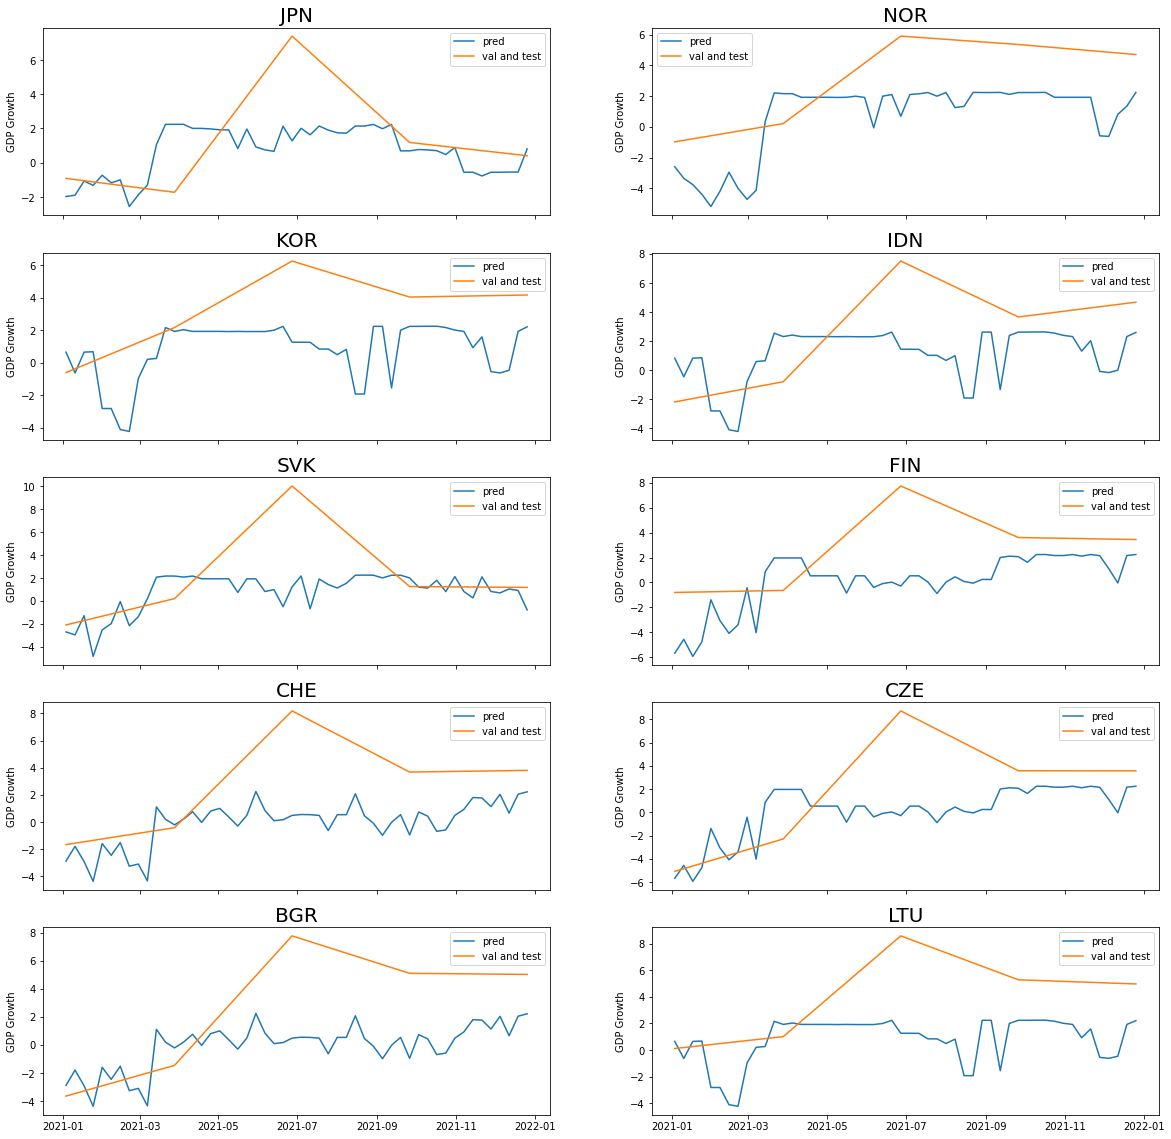

In [119]:
fig, axs = plt.subplots(5, 2, sharex=True, figsize=(20, 20))
date_index = pd.date_range('2021-01-03', periods=52, freq='W') 

for ticker, ax in zip(best_mses, axs.reshape(-1)):
    ind_pred = y_pred_best[np.array(gdp_test_final[f'location_{ticker[1][-3:]}'] == 1)]
    ind_data = np.array(gdp_test_final[gdp_test_final[f'location_{ticker[1][-3:]}'] == 1]['value'])
    
    ax.plot(date_index, ind_pred, label='pred')
    ax.plot(date_index, ind_data, label='val and test')
    
    ax.legend()
    ax.set_title(f'{ticker[1][-3:]}',fontsize = 20)
    ax.set_ylabel('GDP Growth')

График для России:

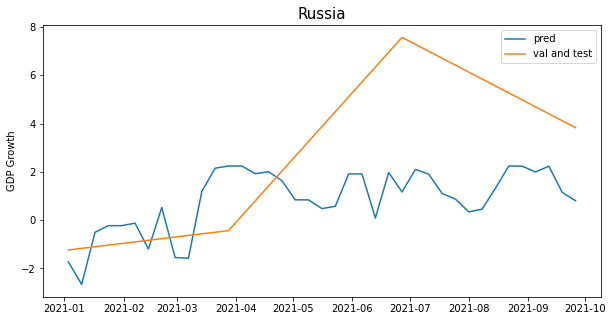

In [117]:
plt.figure(figsize=(10, 5))
date_index = pd.date_range('2021-01-03', periods=39, freq='W') 

ind_pred = y_pred_best[np.array(gdp_test_final[f'location_RUS'] == 1)]
ind_data = np.array(gdp_test_final[gdp_test_final[f'location_RUS'] == 1]['value'])

plt.plot(date_index, ind_pred, label='pred')
plt.plot(date_index, ind_data, label='val and test')

plt.legend()
plt.title(f'Russia',fontsize = 15)
plt.ylabel('GDP Growth');

# MLP Regressor - Base model
Полносвязная нейронная сеть, обучаемая на квартальных данных. Гиперпараметры подбираются на валидационной выборке. Для контроля качества на валидации используются две метрики: MSE, а также среднее гармоническое средних ошибок 20 стран с наименьшим MSE и общей ошибки(MSE на всех странах)

In [23]:
from sklearn.neural_network import MLPRegressor

In [24]:
def train_all(X_train, y_train, X_val, size, lr, iters=6):
    preds_tot = np.zeros(X_val.shape[0])  # предсказания для всех стран
    
    # запускаем несколько раз для стабильности, выходы усредняем
    for i in range(iters):
        network = MLPRegressor(hidden_layer_sizes=size,
                               solver="adam",
                               activation="relu",
                               learning_rate_init=lr, 
                               tol=1e-4,
                               max_iter=7000,
                               early_stopping=True,
                               random_state=i)
        network.fit(X_train, y_train)
        
        # предсказания для всех стран
        preds_tot += np.array(network.predict(X_val))
        
    preds_tot /= iters
    return preds_tot

In [25]:
hidden_sizes = [(100, 10), (100, 15), (110, 10), (110, 15), (120, 10), (120, 15), (140, 10), (150, 10), 
                (160, 10), (170, 10), (200, 10), (140, 20), (150, 20), (160, 20), (170, 20), (200, 20),
                (230, 10), (250, 10), (270, 10), (300, 10)]

learning_rates = [0.0005, 0.0007, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.004, 0.005]

**Подбор параметров нейронной сети** \
Для подбора гиперпараметров используется метрика следующего вида: H(mean_20, mse), где H - гармоническое среднее, mean_20 - среднее mse для 20 стран с наименьшими mse на валидационной выборке, mse - общее MSE для всех стран. Такая метрика используется для того, чтобы уделить особое внимание странам, на которых мы ошибаемся меньше всего. Так как мы предполагаем, что среди рассматриваемых стран будут такие, на которых наша модель не будет показывать удовлетворительные результаты, а то есть использовать построенный индикатор нельзя, лучше будет сосредоточиться хотя бы на 20 самых успешных с точки зрения MSE. В данном случае число стран с наименьшей ошибкой - тоже своего рода гиперпараметр. Мы решили остановиться именно на 20

In [ ]:
print('MSE Total\t Harm mean\t size\t\t lr')
for size in hidden_sizes:
    for lr in learning_rates:
        preds_tot = train_all(X_train, y_train, X_val, 
                              size, lr, iters=6)
        preds_df = X_val.iloc[:, -46:]
        preds_df['Prediction'] = preds_tot
        
        mask_rus = (preds_df['COUNTRY_RUS'] == 1)
        preds = preds_df[~mask_rus]['Prediction']    # массив предсказаний для стран, кроме РФ
        preds_rus = preds_df[mask_rus]['Prediction'] # массив предсказаний для РФ
        
        losses = []
        for country in X_val.columns[-46:]:
            country_mask = (preds_df[country] == 1)

            pred_i = preds_df[country_mask]['Prediction'].values
            y_val_i = y_val.values[country_mask]

            losses.append(np.mean((y_val_i - pred_i) ** 2))
        losses = np.array(losses)
        
        # Считаем общий MSE
        mse_tot = np.mean((preds_tot - y_val) ** 2)
        
        # Считаем среднее гармоническое между MSE и MSE_top20
        mse_top20 = np.mean(losses[losses <= np.quantile(losses, 20/46)])
        harm_mean = scipy.stats.hmean([mse_top20, mse_tot])
        
        print(f'{np.round(mse_tot, 5)}\t {np.round(harm_mean, 5)}\t {size}\t {lr}')

In [149]:
print('Best params: size = (110, 15), lr = 0.002')

Best params: size = (110, 15), lr = 0.002


In [ ]:
preds_tot = train_all(X_train, y_train, X_val, 
                      size, lr, iters=6)
preds_df = X_val.iloc[:, -46:]
preds_df['Prediction'] = preds_tot

mask_rus = (preds_df['COUNTRY_RUS'] == 1)
preds = preds_df[~mask_rus]['Prediction']    # массив предсказаний для стран, кроме РФ
preds_rus = preds_df[mask_rus]['Prediction'] # массив предсказаний для РФ


#### Обучение лучшей модели

In [150]:
preds_ens = np.zeros(data_week_final.shape[0])
for i in range(5):
    network = MLPRegressor(hidden_layer_sizes=(110, 15),
                           solver = "adam",
                           activation = "relu",
                           learning_rate_init = 0.002,
                           tol=1e-4,
                           max_iter=7000,
                           early_stopping = True,
                           random_state=i)
    
    network.fit(X_train, y_train)
    preds_ens += network.predict(data_week_final)
    
best_mse = np.mean((gdp_test_final['value'] - preds_ens/5)**2)
print(f'Best MSE on val and test: {best_mse}')

Best MSE on val and test: 36.96428887429182


In [139]:
mses = []
for tick in X_val.columns[-46:]:
    ind_pred = preds_ens[np.array(data_week_final[tick] == 1)] / 5
    ind_data = np.array(gdp_test_final[gdp_test_final[f'location_{tick[-3:]}'] == 1]['value'])
    mses.append([mse(ind_data, ind_pred), tick])

In [148]:
res = pd.DataFrame({'Country': np.array(mses)[:, 1], 
                    'MSE': np.array(mses)[:, 0].astype('float64')})
res.sort_values(by='MSE').reset_index(drop=True)

,Country,MSE
0,COUNTRY_NOR,3.502421
1,COUNTRY_FIN,5.895561
2,COUNTRY_DNK,6.074840
3,COUNTRY_SWE,6.453898
4,COUNTRY_BGR,6.607468
5,COUNTRY_CZE,7.930812
6,COUNTRY_LVA,8.517893
7,COUNTRY_AUS,8.860309
8,COUNTRY_POL,9.756655
9,COUNTRY_DEU,11.444325


#### Построение графиков

In [70]:
def plot_ts(ticker):
    ind_pred = preds_ens[np.array(gdp_test_final[f'location_{ticker}'] == 1)] / 5
    ind_data = np.array(gdp_test_final[gdp_test_final[f'location_{ticker}'] == 1]['value'])
    ax = plt.gca()
    plt.plot(ind_pred, label='pred')
    plt.plot(ind_data, label='val and test')
    ax.legend()
    plt.title(f'{ticker}',fontsize = 25)
    plt.ylabel('GDP Growth')

Графики для 10 самых лучших стран по MSE:

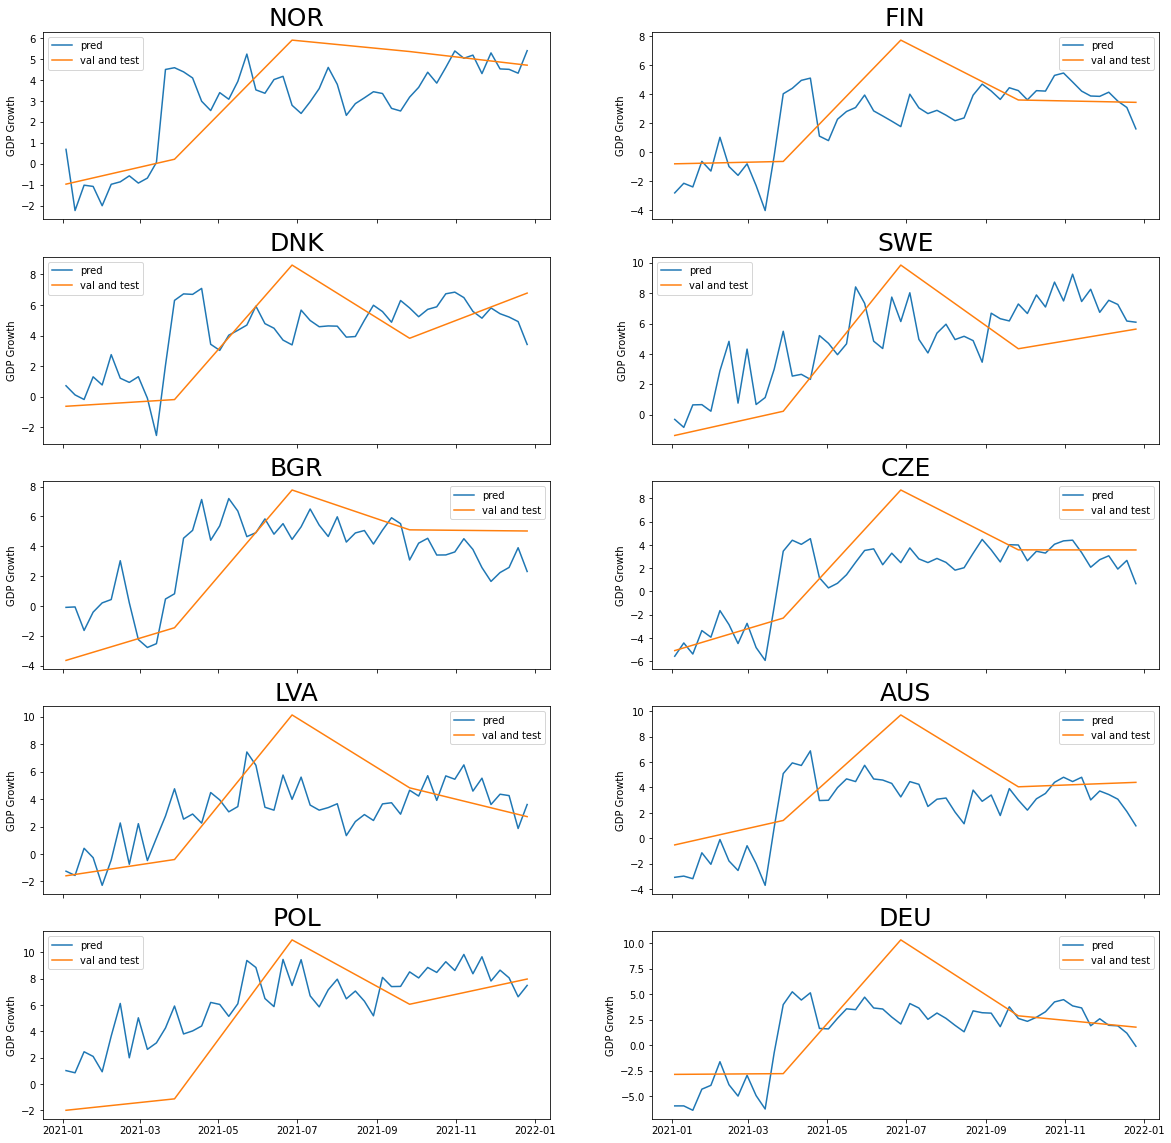

In [83]:
fig, axs = plt.subplots(5, 2, sharex=True, figsize=(20, 20))
date_index = pd.date_range('2021-01-03', periods=52, freq='W') 

for ticker, ax in zip(sorted(mses)[:10], axs.reshape(-1)):
    ind_pred = preds_ens[np.array(gdp_test_final[f'location_{ticker[1][-3:]}'] == 1)] / 5
    ind_data = np.array(gdp_test_final[gdp_test_final[f'location_{ticker[1][-3:]}'] == 1]['value'])
    
    ax.plot(date_index, ind_pred, label='pred')
    ax.plot(date_index, ind_data, label='val and test')
    
    ax.legend()
    ax.set_title(f'{ticker[1][-3:]}',fontsize = 25)
    ax.set_ylabel('GDP Growth')

График для России:

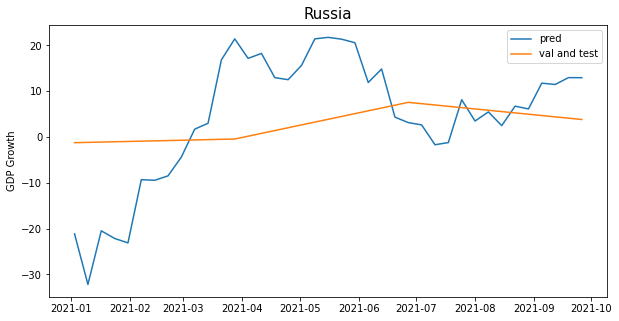

In [120]:
plt.figure(figsize=(10, 5))
date_index = pd.date_range('2021-01-03', periods=39, freq='W') 

ind_pred = preds_ens[np.array(gdp_test_final[f'location_RUS'] == 1)]
ind_data = np.array(gdp_test_final[gdp_test_final[f'location_RUS'] == 1]['value'])

plt.plot(date_index, ind_pred, label='pred')
plt.plot(date_index, ind_data, label='val and test')

plt.legend()
plt.title(f'Russia',fontsize = 15)
plt.ylabel('GDP Growth');

### Выводы
Как мы можем убедиться, для большинства стран (не включая Россию) индикатор действительно повторяет направление изменения прироста ВВП, существование ошибки может заключаться в недостаточном количестве признаков, шуме в данных и, что самое очевидное, в том, что данные для ВВП не являются 'настоящими' - это всего лишь линейная интерполяция.

Из полученных результатов видно, что полносвязная сеть показывает себя лучше стат. моделей и бустинга. Поэтому можно считать, что индикатор экономической активности построен относительно успешно.